# Appliying machine learning to Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)

    * [Distribution of runners across time](#Distribution-of-runners-across-time)
    * [Distribution of #editions, per race](#Distribution-of-#editions,-per-race)
    * [Distribution of #runners, per race](#Distribution-of-#runners,-per-race)
    * [Distribution of #races, per runner](#Distribution-of-#races,-per-runner)
    * [Performance VS Age](#Performance-VS-Age)
    * [Performance VS Weather](#Performance-VS-Weather)
    
    
    
* [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 


---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

## Exploratory statistics

### Loading the dataset

In [3]:
full_df = pd.read_pickle('../../df_userID.pickle')

print(full_df.shape)
print('\n Number of nulls: \n\n',full_df.isnull().sum())
print('\n Data-type: \n\n',full_df.dtypes)
full_df.head(3)

(1648676, 19)

 Number of nulls: 

 Race                0
Date                0
RaceYear            0
RaceMonth           0
Category            0
Distance            0
Name                0
Sex                 0
Year            36620
LivingPlace         0
Rank                0
Time                0
Pace                0
Place               0
MinTemp        546671
MaxTemp        546671
Weather        546671
RaceID              0
UserID              0
dtype: int64

 Data-type: 

 Race                    object
Date                    object
RaceYear                 int64
RaceMonth                int64
Category                object
Distance               float64
Name                    object
Sex                     object
Year                   float64
LivingPlace             object
Rank                     int64
Time           timedelta64[ns]
Pace           timedelta64[ns]
Place                   object
MinTemp                float64
MaxTemp                float64
Weather              

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


#### Remove useless features

In [4]:
full_df.drop('Date',axis=1,inplace=True)
full_df.drop('Rank',axis=1,inplace=True)
full_df.drop('Category',axis=1,inplace=True)

------

Fixing `Date` feature:

_ better not running the following cell _ - it takes ~ 2 min

In [4]:
# %%time

# full_df.Date = [pd.to_datetime(my_date.split(' ')[1],format='%d.%m.%Y').date()
#                 for my_date in full_df.Date]

# full_df.Date = full_df.Date.astype('datetime64')

Fixing `Distance` feature:

In [7]:
full_df.Distance = full_df.Distance.round()
full_df.Distance.unique()

array([  15.,    6.,    2.,    1.,    0.,   20.,   12.,    4.,   10.,
         16.,    5.,    3.,    8.,    9.,   14.,   21.,    7.,   11.,
         17.,   18.,   27.,   42.,   13.,   19.,   26.,  100.,   39.,
         56.,   77.,   25.,   75.,   41.,   30.,   46.,   31.,   50.,
         22.,   51.,  101.,   38.,   90.,   24.,  125.,  200.,   35.])

### Distribution of runners across time
(mind that data are binned by year - each runner might _compete several times_ in the same year)

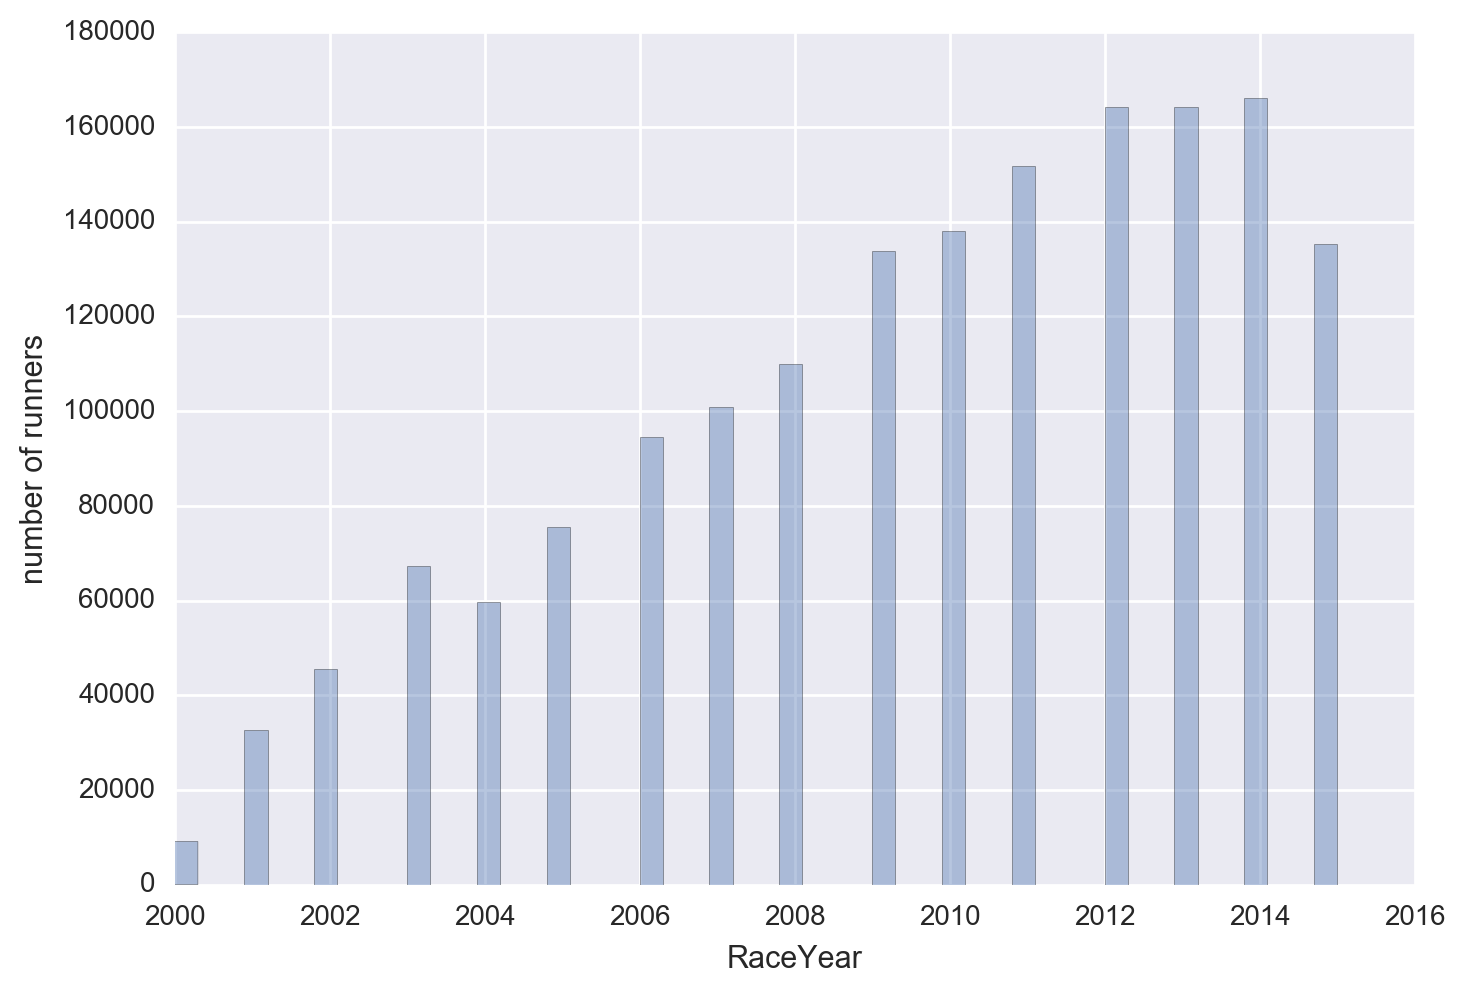

In [10]:
sns.distplot(full_df.RaceYear,kde=False)
plt.ylabel('number of runners');

It might be also intersting to see, in which month _along the year_, most of the events happened:

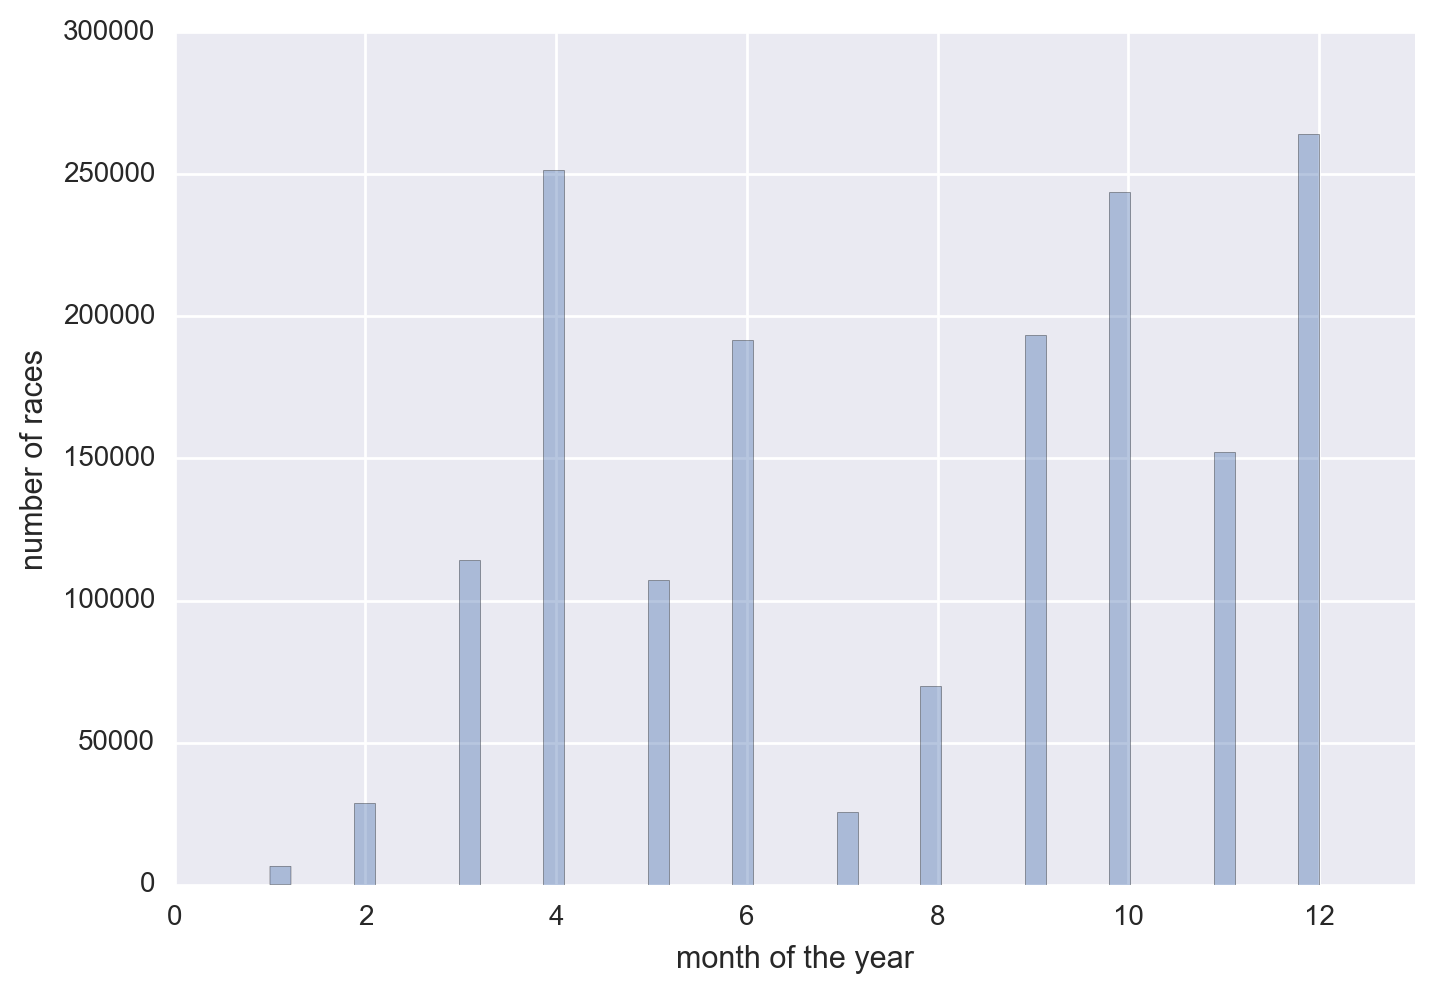

In [11]:
sns.distplot(full_df.RaceMonth,kde=False)
plt.xlabel('month of the year')
plt.xlim([0,13])
plt.ylabel('number of races');

### Distribution of #editions, per race

In [12]:
print('Number of unique races:',full_df.Race.nunique())

Number of unique races: 223


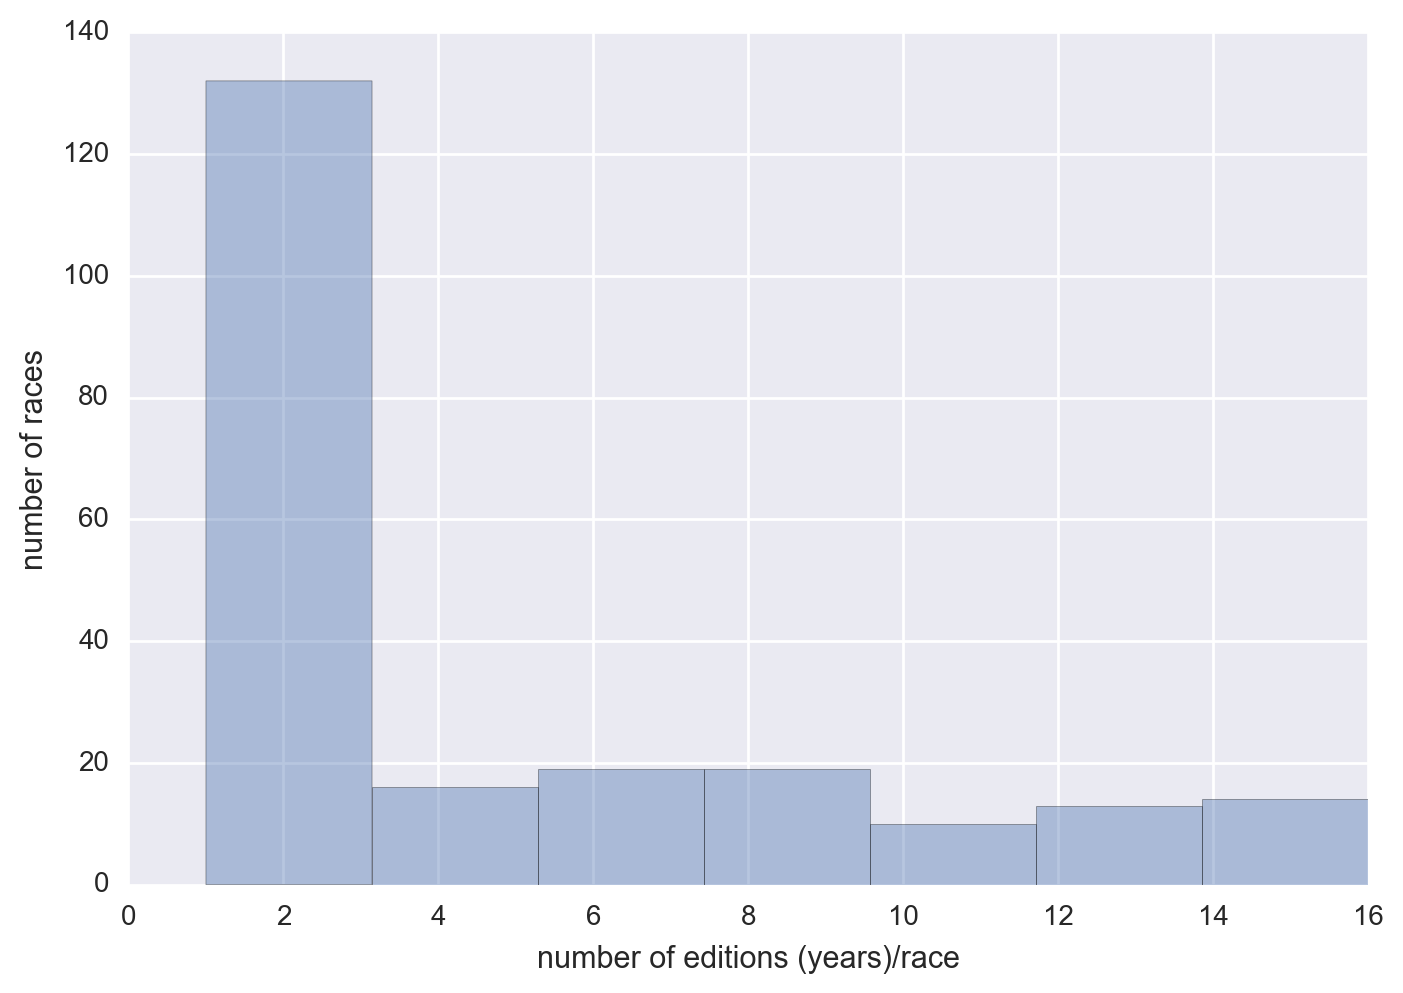

In [13]:
fast_edi_count = full_df.groupby('Race').RaceYear.nunique()

sns.distplot(fast_edi_count.values,kde=False)
plt.xlabel('number of editions (years)/race')
plt.ylabel('number of races');

These are the first 20 __most frequent races__ in the history:

In [14]:
sorted(fast_edi_count.items(),key=lambda x:x[1],reverse=True)[:20]

[('Chäsitzerlouf, Kehrsatz', 16),
 ('20km de Lausanne', 15),
 ('Basler Stadtlauf', 15),
 ('Frauenfelder', 15),
 ('Gurtenclassic, Wabern', 15),
 ('Kerzerslauf', 15),
 ('Schweizer Frauenlauf Bern', 15),
 ('Badener Limmat-Lauf, Baden', 14),
 ('Dietiker Neujahrslauf, Dietikon', 14),
 ('GP Fricktal, Eiken', 14),
 ('Hallwilerseelauf, Beinwil am See', 14),
 ('Kyburglauf, Kyburg', 14),
 ('Langenthaler Stadtlauf', 14),
 ('Pfingstlauf Wohlen AG', 14),
 ('ASICS Bremgarter Reusslauf', 13),
 ("Course de l'Escalade, Genève", 13),
 ('Hellebardenlauf Sempach', 13),
 ('Steinhölzlilauf, Liebefeld', 13),
 ('Thuner Stadtlauf, Thun', 13),
 ('Walliseller Lauf, Wallisellen', 13)]

### Distribution of #runners, per race  
(how popular is a race?)

In [15]:
# note that the UserID is still not 'perfect' 
print('(under) estimation of number of runners:',full_df.UserID.nunique())

(under) estimation of number of runners: 531426


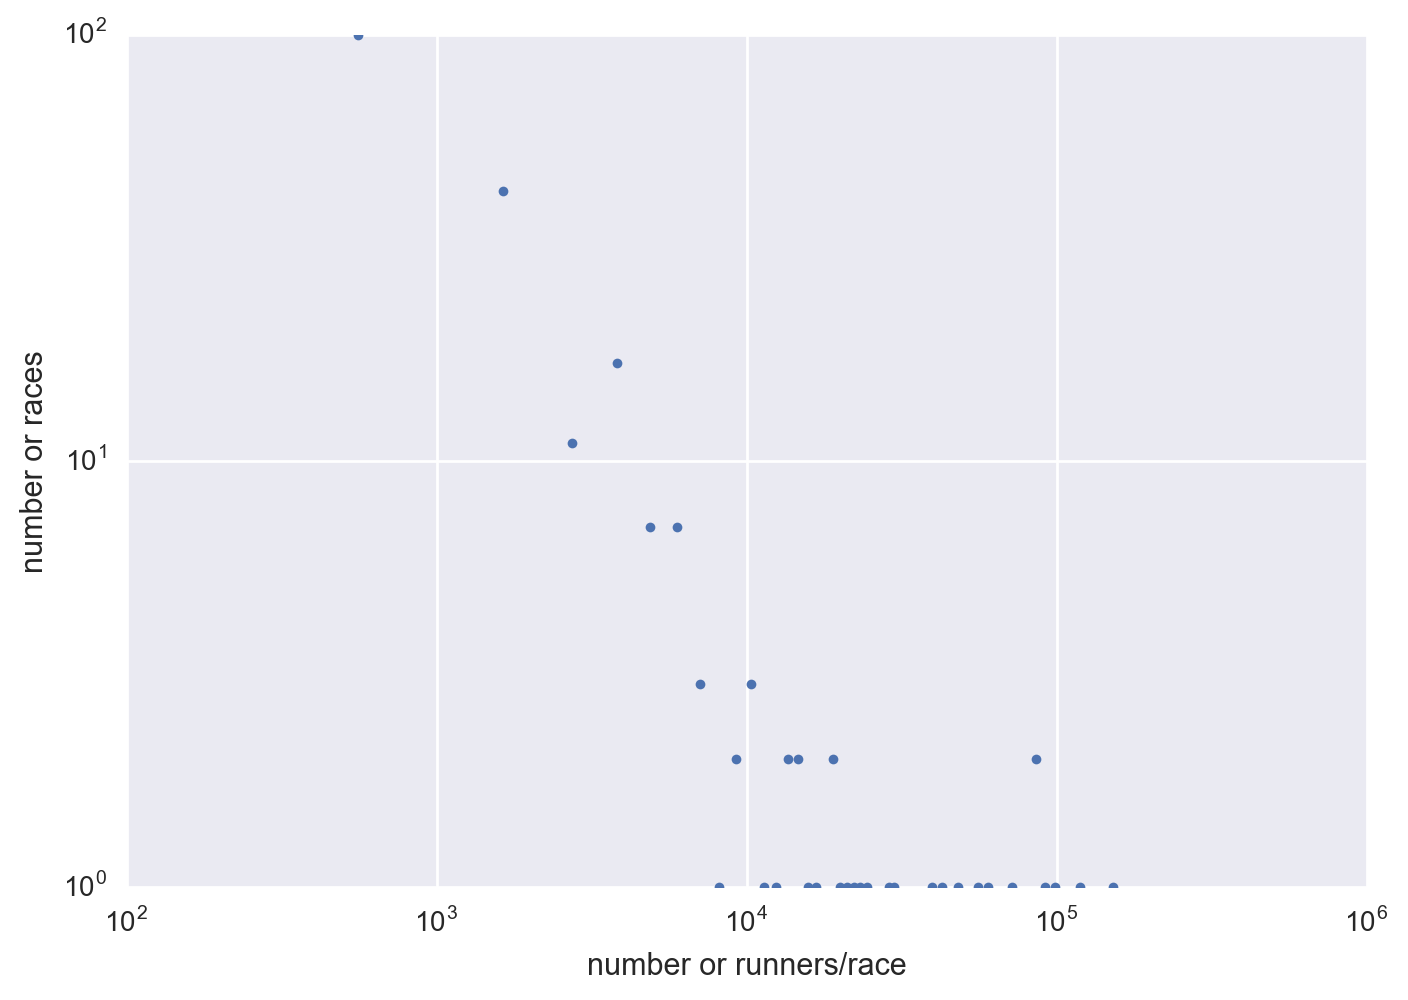

In [16]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race');

### Distribution of #races, per runner
(how active is a runner?)

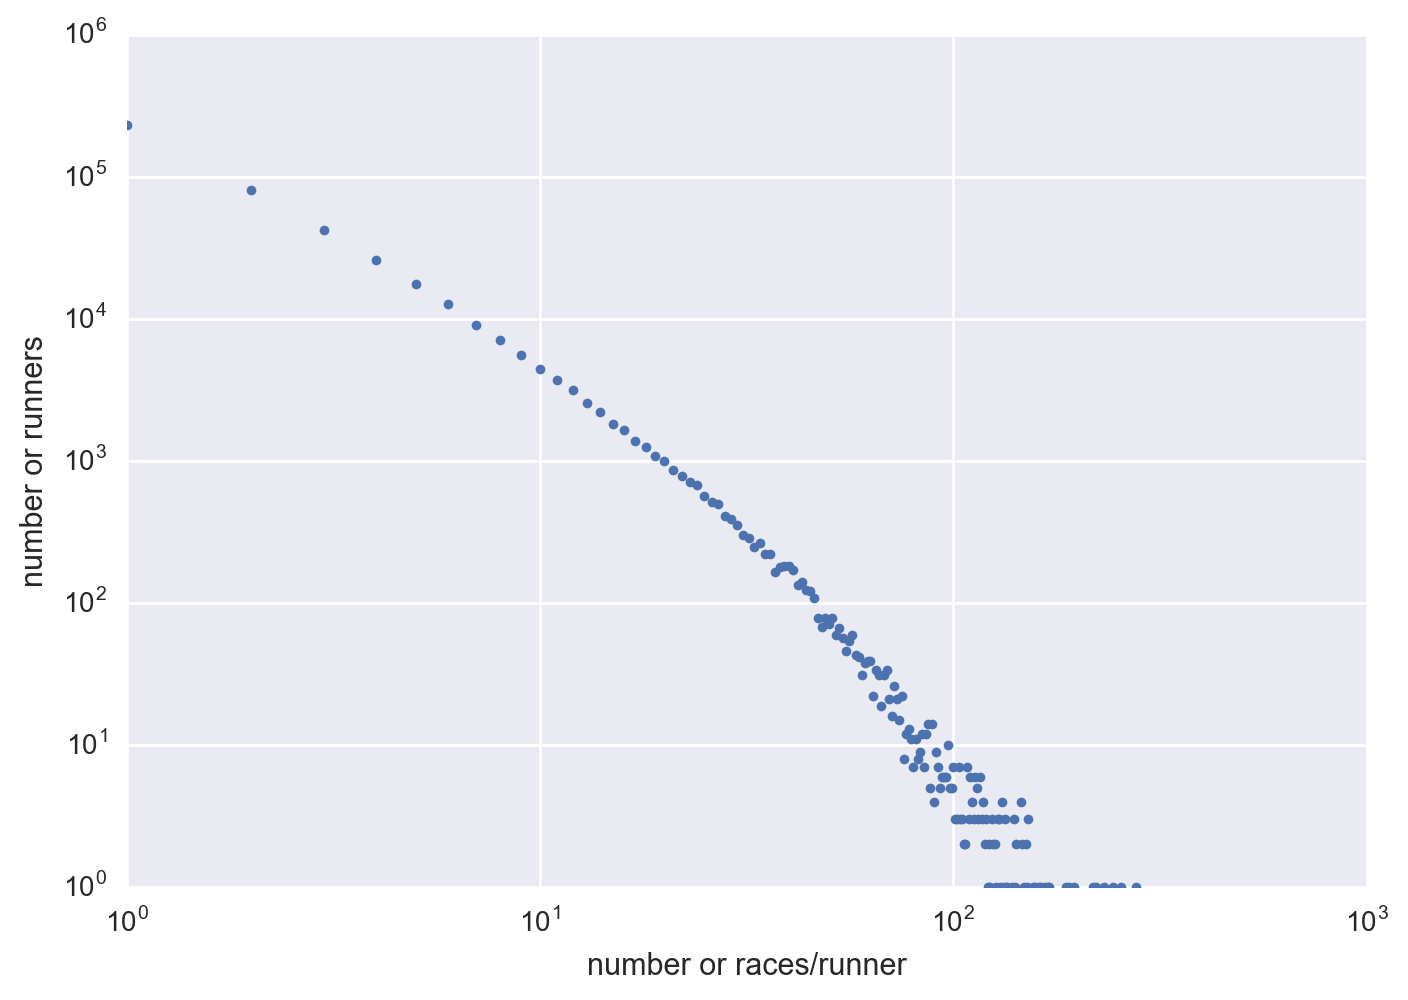

In [17]:
plt.loglog(full_df.Name.value_counts().value_counts(),marker='.',linestyle='')
plt.ylabel('number or runners')
plt.xlabel('number or races/runner');

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

Let's consider for simplicity the races with largest number of runners (across all editions):

In [18]:
runners_count = full_df.Race.value_counts().sort_values(ascending=False)
runners_count[:20]

Course de l'Escalade, Genève            152815
Schweizer Frauenlauf Bern               118906
20km de Lausanne                         98783
Morat-Fribourg                           91950
Kerzerslauf                              86246
Zürcher Silvesterlauf, Zürich            86113
Int Greifenseelauf, Uster                71820
Zürich Marathon, Teamrun und Cityrun     60660
Basler Stadtlauf                         55896
Hallwilerseelauf, Beinwil am See         48263
Jungfrau-Marathon, Interlaken            42470
Lausanne Marathon                        39957
Lucerne Marathon, Luzern                 29938
ASICS Bremgarter Reusslauf               28377
SwissCityMarathon - Lucerne, Luzern      24455
Corrida Bulloise, Bulle                  22891
Luzerner Stadtlauf                       22652
Stralugano, Lugano                       21546
Winterthur Marathon                      20538
Frauenfelder                             19400
Name: Race, dtype: int64

#### Check races distances for each event  
We consider _only races with standard running distances_ - like, 10Km, 20Km, 1/2 marathon and marathon.  
Here are some examples:

In [19]:
full_df[full_df.Race=='20km de Lausanne'].Distance.unique()

array([ 20.,  18.,   4.,  10.,   2.])

In [20]:
full_df[full_df.Race=='Schweizer Frauenlauf Bern'].Distance.unique()

array([  5.,  10.])

In [21]:
full_df[full_df.Race=='Zürich Marathon, Teamrun und Cityrun'].Distance.unique()

array([ 42.,  10.])

In [22]:
full_df[full_df.Race=='Lucerne Marathon, Luzern'].Distance.unique()

array([ 42.,  21.,   8.])

In [23]:
full_df[full_df.Race=='SwissCityMarathon - Lucerne, Luzern'].Distance.unique()

array([ 21.,   9.,  42.])

In [24]:
full_df[full_df.Race=='Winterthur Marathon'].Distance.unique()

array([ 21.,  42.,  10.,   1.,   5.])

In [25]:
full_df[full_df.Race=='Lausanne Marathon'].Distance.unique()

array([ 10.,  21.,  42.,   4.,   3.,   1.,   2.])

#### Subsetting data

In [60]:
good_races = full_df.Race.isin(['Lausanne Marathon','Winterthur Marathon',
                               'Zürich Marathon, Teamrun und Cityrun',
                               'Lucerne Marathon, Luzern'])
# '20km de Lausanne','Schweizer Frauenlauf Bern'
# 'SwissCityMarathon - Lucerne, Luzern'])

copy_for_U = full_df[good_races].copy()

marathon_distance = full_df.Distance == 42

In [66]:
copy_for_U.Time = full_df.Time.astype('timedelta64[m]')
copy_for_U.Time[:3]

47958     97.0
47959     98.0
47960    108.0
Name: Time, dtype: float64

#### Plot       data for marathon

In [139]:
copy_for_U.Year = 2016 - copy_for_U.Year

/Users/lazzari/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


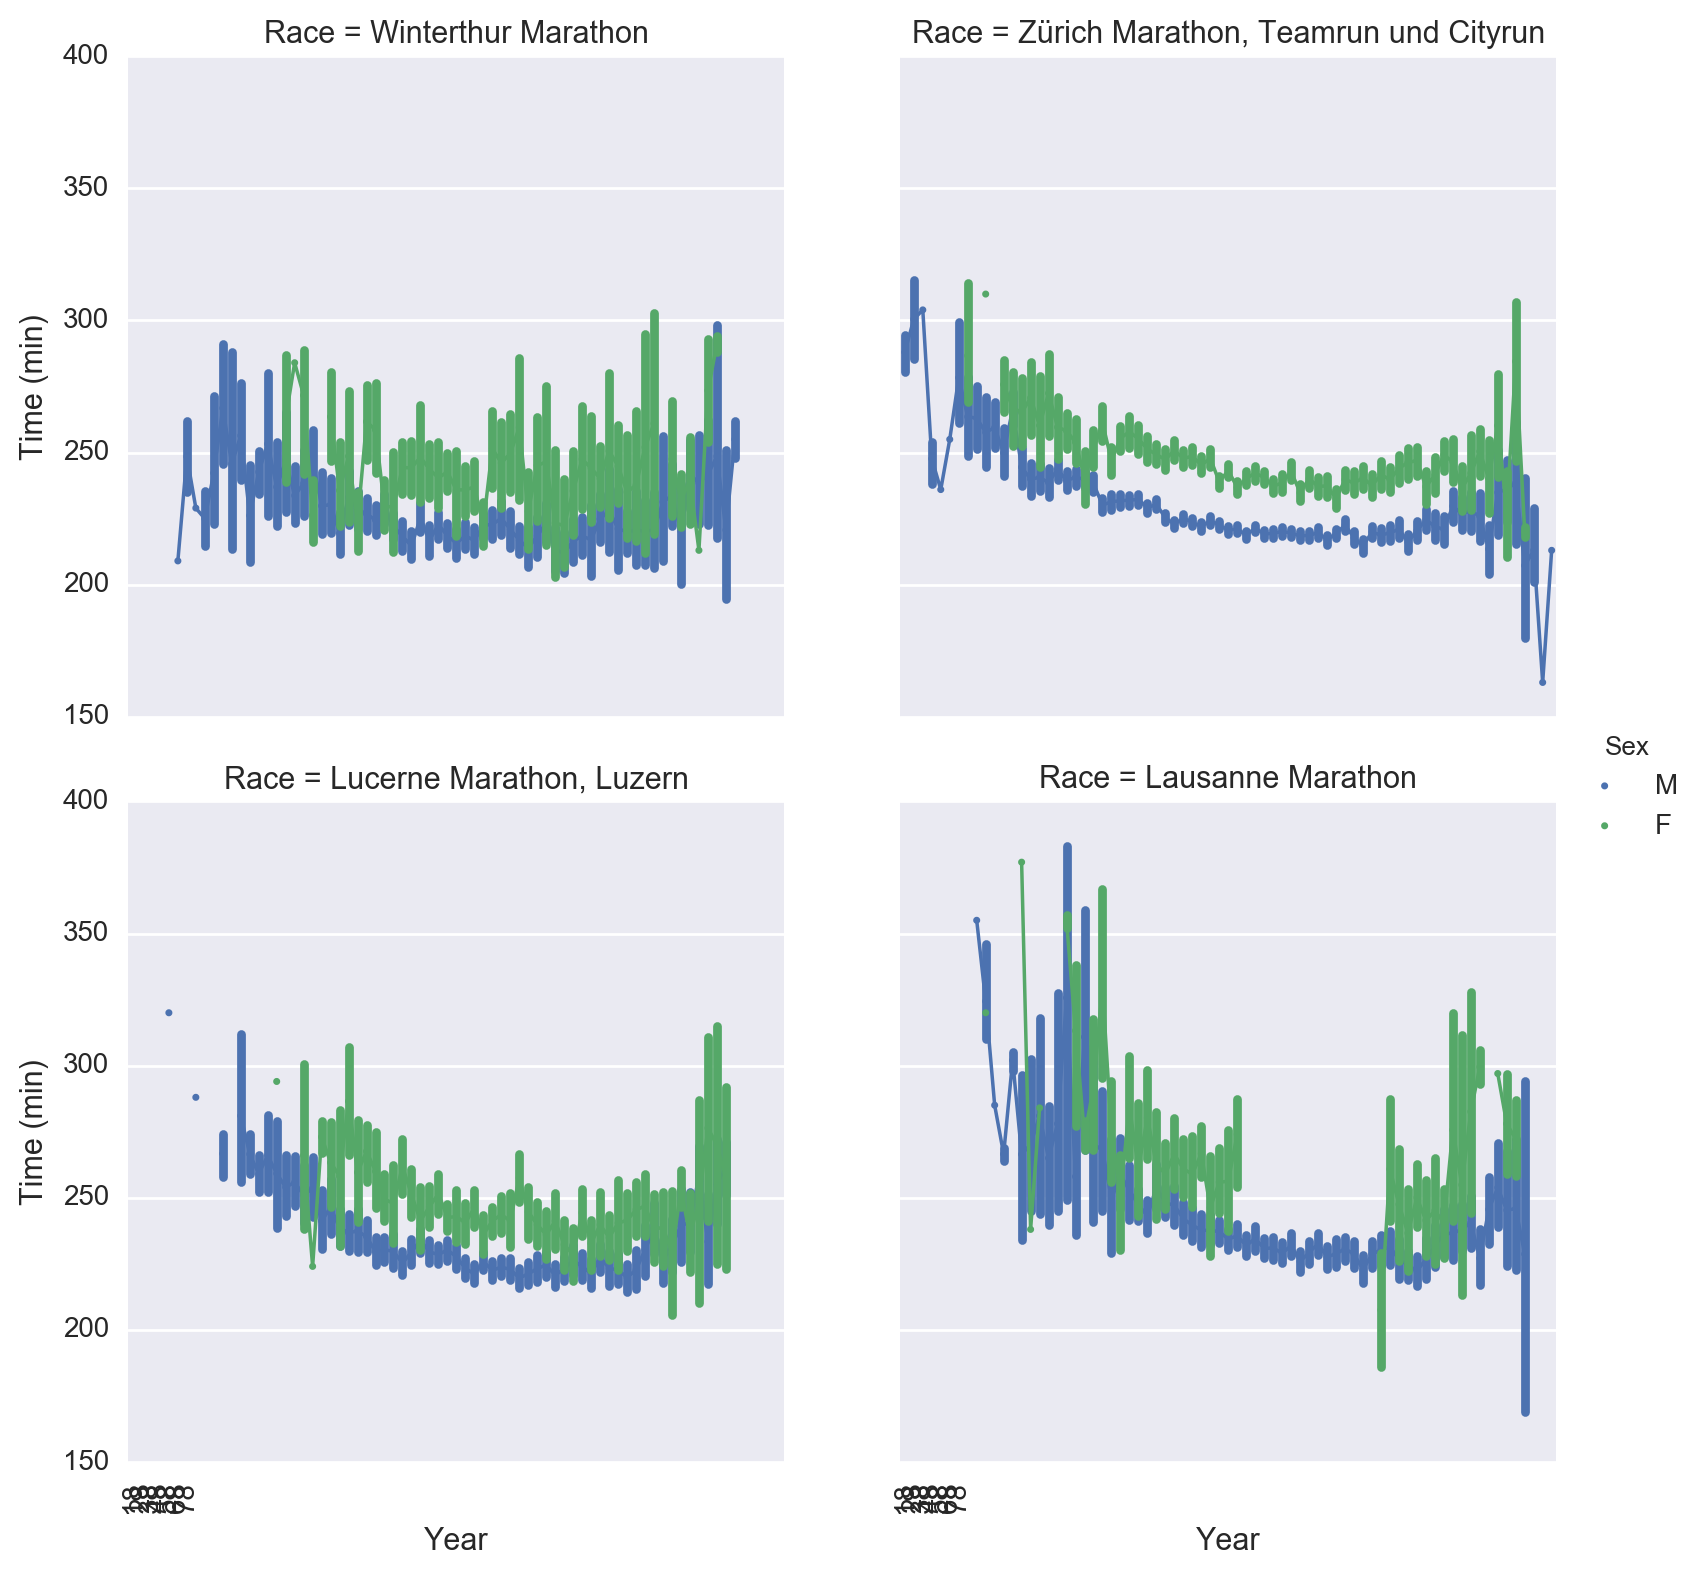

In [145]:
g = sns.factorplot(data=copy_for_U[marathon_distance],
                   x='Year',y='Time',
                   hue='Sex',col='Race',
                   scale=0.4,markers='.',
                   col_wrap=2);

g.set_xticklabels(np.arange(18,85,10),rotation=90)
g.set_ylabels('Time (min)');

# sns.FacetGrid.set(xticks=np.arange(18,85,10))

# g = sns.pointplot(data=copy_for_U[marathon_distance &
#                                   (copy_for_U.Race=='Lausanne Marathon')],
#                   x='Year',y='Time',hue='Sex',
#                   scale=0.5)
# plt.xticks(rotation=90);
# g.xaxis.set_ticks(np.arange(18,85,10));

# [1910,1930,1950,1970,1990,2010]

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners.  
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of ambient temperature on resistance in cyclists)

#### exploring features

In [40]:
# sns.jointplot(full_df.groupby('Race').MinTemp.unique(),
#               full_df.groupby('Race').MaxTemp.unique(),
#               kind='kde');

## ML-driven analysis

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.

In [2]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# ------   OLD CODE ------

In [6]:
# num_runners = 0

# for name in  full_df.Name.unique():
            
#     num_runners += full_df[full_df.Name==name].Year.nunique()